# Image Segmentation with U-Net

# 1. Setup

## 1.1 Install dependencies 

In [1]:
# Installing packages
!python -m pip install --upgrade pip
!python -m pip install --upgrade Pillow
!python -m pip install tensorflow

## 1.2 Import dependencies

In [2]:
# for loading data
import os

# for reading and processing images
import imageio
from PIL import Image
import cv2

# for visualizazions
import matplotlib.pyplot as plt
from identify import identify
import pandas as pd

# data set split

from sklearn.model_selection import train_test_split

#  for using np arrays
import numpy as np

# for building and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Conv2DTranspose, concatenate
#from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

## 1.3 Set GPU growth 

In [3]:
# Avoid OOM errors by setting GPU Memory Consumpthion

gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## 2. Helper Functions for Data Processing 

### 2.1 Load Data  

In [4]:
def load_data(path_img, path_mask): 
    """
    Looks for relevant filenames in the shared path 
    Return: two list for original and masked files respectively
    """
    
    # Read the images folder like a list
    dataset_img = os.listdir(path_img)
    dataset_mask = os.listdir(path_mask)
#     dataset_img = tf.data.Dataset.list_files(path_img + '\*.jpg')
#     dataset_mask = tf.data.Dataset.list_files(path_mask + '\*.png')
    
    # Make lists for images and masks  filename
    img_orig = []
    img_mask = []
    
    for file in dataset_img:
        img_orig.append(file)
    for file in dataset_mask:
        img_mask.append(file)
        
    # Sort the lists to make both of them in the same order
    # print(img_orig)
    
    img_orig.sort()
    img_mask.sort()
    
    return img_orig, img_mask

In [5]:
# test_image_path = os.path.join('pet_dataset', 'new_dataset', 'annotations', 'annotations', 'trimaps', 'Abyssinian_1.png')
# image = imageio.imread(test_image_path)
# plt.imshow(image)

In [6]:
# !pip install identify
# identify.tags_from_path(test_image_path)

In [7]:
# import io
# import os
# import tensorflow as tf
# import PIL
# import matplotlib.pyplot as plt
# import numpy as np
# import cv2

# # read image file as byte type
# with tf.io.gfile.GFile(test_image_path, 'rb') as fid:
#     encoded_mask_png = fid.read()
# # write the byte info
# encoded_png_io = io.BytesIO(encoded_mask_png)

# # open
# mask = PIL.Image.open(encoded_png_io) 
# plt.imshow( np.array(mask) / 2 * 255)

### 2.2 Pre-Process Data 

In [8]:
def preprocess_data(img, mask, target_shape_img, target_shape_mask, path_img, path_mask):
    
    # Pull the relevant dimentions of the image and mask 
    total_img = len(img)
    
    h_img, w_img, c_img = target_shape_img
    h_mask, w_mask, c_mask = target_shape_mask
    
    # Define X and y with number of images along with the shape of one image
    X = np.zeros((total_img, h_img, w_img, c_img), dtype = np.float32)
    y = np.zeros((total_img, h_mask, w_mask, c_mask), dtype = np.int32)
    
    # Resize images and mask
    for file in img:
        # Convert image into an array of desired shape
        index = img.index(file)
        path = os.path.join(path_img, file)
        image = Image.open(path).convert('RGB')
        image = image.resize((h_img, w_img))
        image = np.reshape(image, (h_img, w_img, c_img))
        image = image/255
        X[index] = image
        
#     for file in mask: 
        # Concert image into an array of desired shape
        mask_index = mask[index]
        path = os.path.join(path_mask, mask_index)
        single_mask = Image.open(path)
        single_mask = single_mask.resize((h_mask, w_mask))
        single_mask = np.reshape(single_mask, (h_mask, w_mask, c_mask))
        single_mask = single_mask -1 # for convinence to start class from 0 (1, 2, 3) -> (0, 1, 2)
        y[index] = single_mask
        
    return X, y

# 3. Visualize data

## 3.1 Load data and visualize raw data 

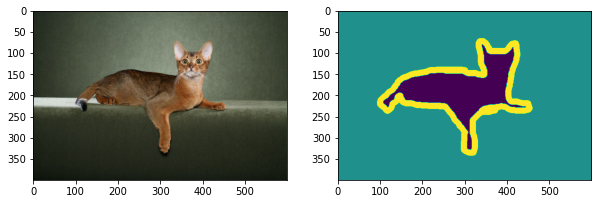

In [9]:
# Load the data

path_raw_image = os.path.join('pet_dataset', 'new_dataset', 'images', 'images')
path_raw_mask = os.path.join('pet_dataset', 'new_dataset', 'annotations', 'annotations','trimaps')
images, masks = load_data(path_raw_image, path_raw_mask) 

single_image_path = os.path.join(path_raw_image, images[0])
single_mask_path = os.path.join(path_raw_mask, masks[0])

image = imageio.imread(single_image_path)
mask = imageio.imread(single_mask_path)
# Set plot size
plt.figure(figsize=(10,8))

#Set first subplot
plt.subplot(1,2,1)
plt.imshow(image)

plt.subplot(1,2,2)
plt.imshow(mask)

plt.show()
# print(images)

## 3.2 Process and visualize the data 

X shape: (7390, 128, 128, 3)
y shape: (7390, 128, 128, 1)


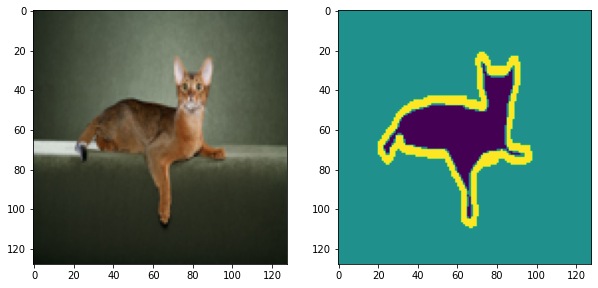

In [10]:
# Preprocess the data
target_shape_img = [128, 128, 3]
target_shape_mask = [128, 128, 1]

X, y = preprocess_data(images, masks, target_shape_img, target_shape_mask, path_raw_image, path_raw_mask)

print("X shape:", X.shape)
print("y shape:", y.shape)

# Set plot size
plt.figure(figsize=(10,8))

#Set first subplot
plt.subplot(1,2,1)
plt.imshow(X[0])

plt.subplot(1,2,2)
plt.imshow(y[0])

plt.show()
# print(images)

## 3.3 Split data 

In [11]:
# Split trainging data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)

# 4. U-Net model

## 4.1 U-Net Encoder Block 

In [12]:
def unit_encoder_block(block_input, n_filter=32, dropout_prob=0.3, max_pooling=True):
    en_layer = Conv2D(n_filter, 
                  kernel_size = 3,
                   activation = 'relu',
                   padding ='same',
                   kernel_initializer = 'HeNormal'
                  )(block_input)
    
    en_layer = Conv2D(n_filter, 
                  kernel_size = 3,
                   activation = 'relu',
                   padding ='same',
                   kernel_initializer = 'HeNormal'
                  )(en_layer)
    
    en_layer = BatchNormalization()(en_layer, training=False)
    
    # Reduce overfitting
    if dropout_prob > 0:
        en_layer = Dropout(dropout_prob)(en_layer)
        
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2, 2))(en_layer)
    else:
        next_layer = en_layer
    
    skip_connection = en_layer
    
    return next_layer, skip_connection

## 4.2 U-Net Decoder Block 

In [13]:
def unit_decoder_block(block_input, skip_connection, n_filter=32):
    de_layer = Conv2DTranspose(n_filter,
                              kernel_size=(3,3),
                               strides=(2,2),
                              padding='same')(block_input)
    
    de_layer = concatenate([skip_connection, de_layer], axis=3)
    
    de_layer = Conv2D(n_filter,
                      kernel_size=3,
                      activation = 'relu',
                      padding='same',
                      kernel_initializer='HeNormal')(de_layer)
    
    de_layer = Conv2D(n_filter,
                  kernel_size=3,
                  activation = 'relu',
                  padding='same',
                  kernel_initializer='HeNormal')(de_layer)
    
    
    return de_layer

## 4.3 Full U-Net model 

In [14]:
def u_net_model(input_shape=(128, 128, 3), n_filter=32, n_class=3):
    input_layer = Input(input_shape)
    
    en_block1 = unit_encoder_block(input_layer, n_filter, dropout_prob=0, max_pooling= True)
    en_block2 = unit_encoder_block(en_block1[0], n_filter*2, dropout_prob=0, max_pooling= True)
    en_block3 = unit_encoder_block(en_block2[0], n_filter*4, dropout_prob=0, max_pooling= True)
    en_block4 = unit_encoder_block(en_block3[0], n_filter*8, dropout_prob=0.3, max_pooling= True)
    en_block5 = unit_encoder_block(en_block4[0], n_filter*16, dropout_prob=0.3, max_pooling= False)
    
    de_block6 = unit_decoder_block(en_block5[0], en_block4[1], n_filter*8)
    de_block7 = unit_decoder_block(de_block6, en_block3[1], n_filter*4)
    de_block8 = unit_decoder_block(de_block7, en_block2[1], n_filter*2)
    de_block9 = unit_decoder_block(de_block8, en_block1[1], n_filter)
    
    conv10 = Conv2D(n_filter,
                 kernel_size=3,
                 activation='relu',
                 padding='same',
                   kernel_initializer='he_normal')(de_block9)
    
    conv11 = Conv2D(n_class, 1, padding='same')(conv10)
    
    # Define the model
    model = tf.keras.Model(inputs=input_layer, outputs=conv11)
    
    return model
    

# 5. Train and Evaluete the model

## 5.1 Training 

In [15]:
# create model
unet = u_net_model(input_shape=(128,128,3), n_filter=32, n_class=3)
# unet.summary()

In [16]:
# compile model

unet.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [17]:
# Fit the model

results = unet.fit(X_train, y_train, batch_size=32, epochs = 20, validation_data=(X_val, y_val))

Epoch 1/20
185/185 [==============================] - 38s 163ms/step - loss: 0.7935 - accuracy: 0.6481 - val_loss: 0.6235 - val_accuracy: 0.7465
Epoch 2/20
185/185 [==============================] - 27s 146ms/step - loss: 0.5526 - accuracy: 0.7817 - val_loss: 0.4699 - val_accuracy: 0.8176
Epoch 3/20
185/185 [==============================] - 28s 150ms/step - loss: 0.4544 - accuracy: 0.8247 - val_loss: 0.4416 - val_accuracy: 0.8282
Epoch 4/20
185/185 [==============================] - 31s 168ms/step - loss: 0.3966 - accuracy: 0.8487 - val_loss: 0.3894 - val_accuracy: 0.8519
Epoch 5/20
185/185 [==============================] - 28s 152ms/step - loss: 0.3676 - accuracy: 0.8594 - val_loss: 0.3825 - val_accuracy: 0.8522
Epoch 6/20
185/185 [==============================] - 29s 155ms/step - loss: 0.3487 - accuracy: 0.8681 - val_loss: 0.3582 - val_accuracy: 0.8660
Epoch 7/20
185/185 [==============================] - 27s 144ms/step - loss: 0.3282 - accuracy: 0.8755 - val_loss: 0.3464 - val_ac

## 5.2 Evaluate the model 

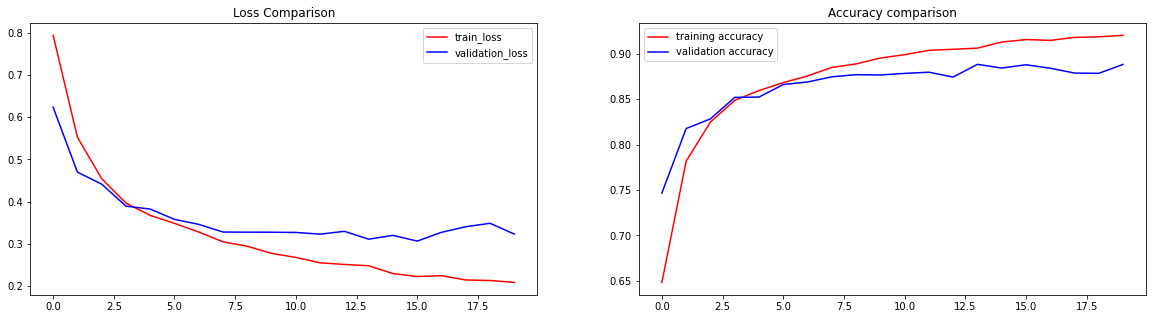

In [31]:
fig, s_plot = plt.subplots(1, 2, figsize=(20, 5))

s_plot[0].plot(results.history["loss"], color='r', label='train_loss')
s_plot[0].plot(results.history["val_loss"], color='b', label='validation_loss')
s_plot[0].set_title('Loss Comparison')
s_plot[0].legend()

s_plot[1].plot(results.history['accuracy'], color='r', label='training accuracy')
s_plot[1].plot(results.history['val_accuracy'], color='b', label='validation accuracy')
s_plot[1].set_title('Accuracy comparison')
s_plot[1].legend()

In [33]:
unet.evaluate(X_val, y_val)

47/47 [==============================] - 2s 44ms/step - loss: 0.3233 - accuracy: 0.8882


[0.3233126103878021, 0.8882142305374146]

## 5.3 Check predictions 

In [119]:
def check_predictions(index):
    img = X_val[index]
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    fig, arr = plt.subplots(1,3, figsize=(15, 15))
    arr[0].imshow(X_val[index])
    arr[0].set_title('Raw image')
    
    arr[1].imshow(y_val[index])
    arr[1].set_title('masked image')
    
    arr[2].imshow(pred_mask)
    arr[2].set_title('predicted mask image')
    
    

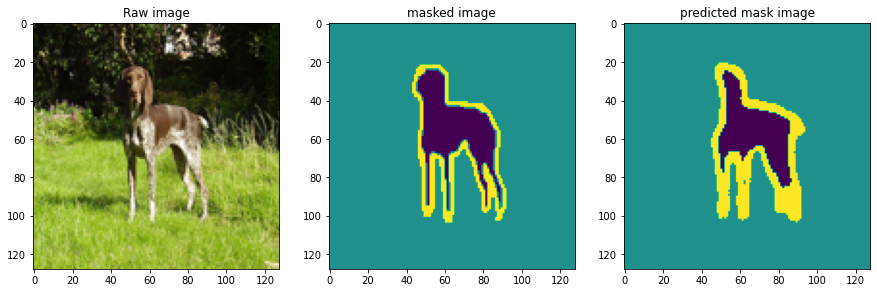

In [120]:
index = 300
check_predictions(index)